# 2. Grouping customers together!

#### Data Cleaning

We need to pre_process our data to delete all the outliers, NA or mistakes and set the time variables in a right form.

In [110]:
from sklearn.preprocessing import normalize
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn import preprocessing
import matplotlib.pyplot as plt
from datetime import datetime
import pandas as pd
import numpy as np
import pyspark
from pyspark.sql import SparkSession
import findspark
import sklearn.metrics
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

In [269]:
bank_data = pd.read_csv("bank_transactions.csv")
bank_data.dropna(inplace=True)
bank_data.CustomerDOB = pd.to_datetime(bank_data.CustomerDOB)
bank_data.TransactionDate = pd.to_datetime(bank_data.TransactionDate)
bank_data.TransactionTime = bank_data.TransactionTime.apply(lambda x: datetime.strptime(str(x).zfill(6), "%H%M%S"))
bank_data = bank_data.rename(columns={'TransactionAmount (INR)':'TransactionAmount'})
bank_data["TransactionTime"] = bank_data["TransactionTime"].dt.hour

<AxesSubplot:>

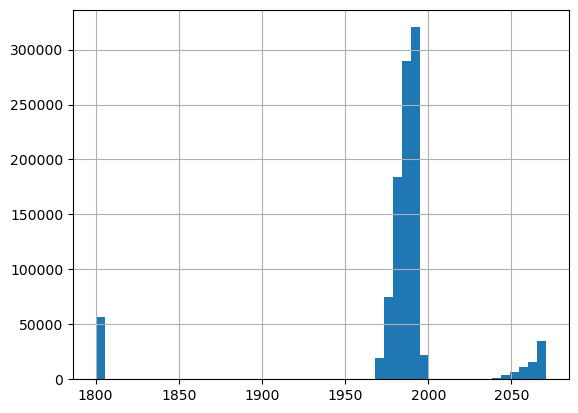

In [112]:
bank_data.CustomerDOB.dt.year.hist(bins=50)

Watching the histogram we can see that there are a lot of people born in 1800 and others in 2050 and after. The last range is a mistake for the millenium bug, so we can fix it by subtracting 100 years in each of this data.

In [270]:
bank_data.drop(bank_data[bank_data.CustomerDOB.dt.year == 1800].index, axis=0, inplace=True)
bank_data.loc[bank_data.CustomerDOB.dt.year > 2000, 'CustomerDOB'] = bank_data.loc[bank_data.CustomerDOB.dt.year > 2000, 'CustomerDOB'] - pd.DateOffset(years = 100)

<AxesSubplot:>

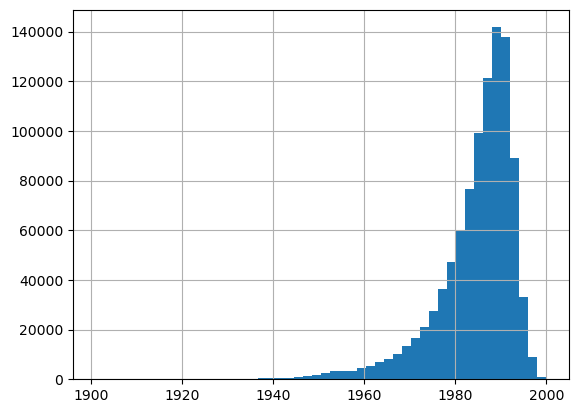

In [114]:
bank_data.CustomerDOB.dt.year.hist(bins=50)

Now the histogram shows right values of birthdays.

In [271]:
bank_data.to_pickle("bankdata")
data = pd.read_pickle("bankdata")

## 2.1 Getting your data + feature engineering

#### Define a new index
Now our purpose is to group by the transaction for each costumer and add new variables to create a dataset of 27 features.
Since we discovered that the CustomerID field is not a good approximation of the customer identity, a combination of fields is being used to identify the user. We will perform the operation of grouping by using newly defined columns which we believe may represent a single customer. In the following cells two strategies are explored, in the first one the location in which a single customer does the transaction is assumed to be not changing, in the second one the balance of a single customer is considered consant. The combination of one of these two fields, along with DOB and gender will be the new identification column.

In [272]:
#New columns
data["NewID1"] = data["CustomerDOB"].astype(str) + data["CustGender"] + data["CustLocation"]
data["NewID2"] = data["CustomerDOB"].astype(str) + data["CustGender"] + data["CustAccountBalance"].astype(str)

In [118]:
data[["CustomerID", "NewID1", "CustAccountBalance", "TransactionAmount"]].groupby(["NewID1"]).agg(lambda x: x.tolist())

,CustomerID,CustAccountBalance,TransactionAmount
NewID1,,,
1901-01-01MDELHI,[C4821377],[11378.03],[4.74]
1901-01-01MKANDIVALI WEST MUMBAI,"[C8513867, C7713887, C7813825, C7813828, C1413...","[222.44, 222.44, 222.44, 222.44, 222.44, 222.4...","[7554.0, 7105.0, 2177.5, 2640.0, 232.0, 1250.0..."
1901-01-01MPALI,[C6817759],[2368.32],[5790.0]
1901-01-05MMUMBAI,"[C1520561, C5920521, C2120581, C3620550]","[521.01, 521.01, 521.01, 521.01]","[650.0, 140.0, 210.0, 366.0]"
1901-01-07MGAUTAM BUDDH NAGAR,"[C5641445, C3941415]","[139.84, 139.84]","[600.0, 199.0]"
...,...,...,...
2000-12-01MSRINAGAR,"[C2110112, C6110173, C7310156]","[24900.78, 24900.78, 24900.78]","[100.0, 3044.0, 65.0]"
2000-12-09MNAVI MUMBAI,"[C5842760, C6442771, C3342730, C6442777, C1942...","[10446.17, 10446.17, 10446.17, 10446.17, 10446...","[620.0, 1114.31, 5668.0, 933.46, 230.0]"
2000-12-20MMUMBAI,"[C7920950, C1520914]","[8774.87, 8774.87]","[195.0, 4721.0]"


In [117]:
data[["CustomerID", "NewID2", "CustLocation", "TransactionAmount"]].groupby(["NewID2"]).agg(lambda x: x.tolist())

,CustomerID,CustLocation,TransactionAmount
NewID2,,,
1901-01-01M11378.03,[C4821377],[DELHI],[4.74]
1901-01-01M222.44,"[C8513867, C7713887, C7813825, C7813828, C1413...","[KANDIVALI WEST MUMBAI, KANDIVALI WEST MUMBAI,...","[7554.0, 7105.0, 2177.5, 2640.0, 232.0, 1250.0..."
1901-01-01M2368.32,[C6817759],[PALI],[5790.0]
1901-01-05M521.01,"[C1520561, C5920521, C2120581, C3620550]","[MUMBAI, MUMBAI, MUMBAI, MUMBAI]","[650.0, 140.0, 210.0, 366.0]"
1901-01-07M139.84,"[C5641445, C3941415]","[GAUTAM BUDDH NAGAR, GAUTAM BUDDH NAGAR]","[600.0, 199.0]"
...,...,...,...
2000-12-01M24900.78,"[C2110112, C6110173, C7310156]","[SRINAGAR, SRINAGAR, SRINAGAR]","[100.0, 3044.0, 65.0]"
2000-12-09M10446.17,"[C5842760, C6442771, C3342730, C6442777, C1942...","[NAVI MUMBAI, NAVI MUMBAI, NAVI MUMBAI, NAVI M...","[620.0, 1114.31, 5668.0, 933.46, 230.0]"
2000-12-20M8774.87,"[C7920950, C1520914]","[MUMBAI, MUMBAI]","[195.0, 4721.0]"


#### Observations
As we can see, we get a list of equal balances when we cosider the location constant and equal locations when considering the balance constant, also worth noting that the CustomerIDs are indeed different. Noting finally that the size of the two grouped by datasets is similar, we can conclude that these two operations yield similar results, corroborating the idea that these new definitions for the customer identity are more refined than CustomerID. One final note is that the majority of customers has multiple associated CustomerIDs. We now proceed to making the dataset, the new index will be the combination of DOB, gender and balance, as it yields slightly more rows.

In [277]:
data['Trans_over_100'] =  data.loc[data['TransactionAmount']>100,'TransactionAmount']
data['Small_transaction'] = data.loc[data['TransactionAmount']<100,'TransactionAmount']
data['Perc_transaction_balance'] = (data['TransactionAmount']/(data['CustAccountBalance']))*100
data['Big_balance'] = data.loc[data['CustAccountBalance']>100000,'CustAccountBalance']
data['Utilisation'] = data['CustAccountBalance']-data['TransactionAmount']
data['CustomerAge'] = ((pd.to_datetime('today') - data.CustomerDOB) / np.timedelta64(1,'Y')).astype(int)
data['Day_week'] = data.TransactionDate.dt.day_of_week
data['Month'] = data.TransactionDate.dt.month
data['Summer'] = data.loc[(data.TransactionDate.dt.month>=6) & (data.TransactionDate.dt.month<=9),'TransactionAmount']
data['Winter'] = data.loc[(data.TransactionDate.dt.month>=12) | (data.TransactionDate.dt.month<=2),'TransactionAmount']
data['Begin_month'] = data.loc[data.TransactionDate.dt.day<=15,'TransactionAmount']

In [283]:
dataframe={
           'Transactions_#':list(data.groupby("NewID2").TransactionID.count()), # Number of transactions
           'Ts_over_100':list(data.groupby("NewID2").Trans_over_100.count()), # Number of transactions over 100 units of currency
           'Small_transactions_#':list(data.groupby("NewID2").Small_transaction.count()), # Number of transactions under 100 units of currency
           'Ave_transaction':list(data.groupby("NewID2").TransactionAmount.mean()), # The average transaction
           'Min_transaction':list(data.groupby("NewID2").TransactionAmount.min()), # The minimum transaction
           'Max_transaction':list(data.groupby("NewID2").TransactionAmount.max()), # The maximum transaction
           'Balance':list(data.groupby("NewID2").CustAccountBalance.first()), # The average balance
           'Mean_%_Tr_balance':list(round((data.groupby("NewID2").Perc_transaction_balance.mean()),1)), # The percentage of the transactions on the balance
           'Average_util':list(data.groupby("NewID2").Utilisation.mean()), # The average utilisation
           'Gender':list(data.groupby("NewID2").CustGender.first()), # The gender most common
           'Location':list(data.groupby("NewID2").CustLocation.agg(lambda x: pd.Series.mode(x)[0])), # The location most common
           'Age':list(data.groupby("NewID2").CustomerAge.first().astype(int)), # The average of the ages
           'Big_balance':list(data.groupby("NewID2").Big_balance.count()), # A boolean for people under (0) or over (1) 100000 in balance
           'Day_week':list(data.groupby("NewID2").Day_week.agg(lambda x: pd.Series.mode(x)[0])), # The most common day of the week
           'Month':list(data.groupby("NewID2").Month.agg(lambda x: pd.Series.mode(x)[0])), # The most common month
           'Summer':list(data.groupby("NewID2").Summer.sum()), # The amount of transactions during summer
           'Winter':list(data.groupby("NewID2").Winter.sum()), # The amount of transactions during winter
           'Begin_month':list(data.groupby("NewID2").Begin_month.sum()), # The amount of transactions during the first half of all months
           "Accounts_#":list(data.groupby("NewID2").CustomerID.count()), # The number of accounts that have each customer
           "Total_expenses":list(data.groupby("NewID2").TransactionAmount.sum()), # The sum of all transactions of a customer
           "1st_quart_Tr":list(data.groupby("NewID2").TransactionAmount.quantile(0.25)), # First quartile of the transactions amount
           "3rd_quart_Tr":list(data.groupby("NewID2").TransactionAmount.quantile(0.75)), # Third quartile of the transactions amount
           "Median_Tr":list(data.groupby("NewID2").TransactionAmount.median()), # Median of the transactions amount
           "Hour":list(data.groupby("NewID2").TransactionTime.agg(lambda x: pd.Series.mode(x)[0])), # Most common hour of the day
           "Median_util":list(data.groupby("NewID2").Utilisation.median()), # Median of utilisation
           "1st_quart_util":list(data.groupby("NewID2").Utilisation.quantile(0.25)), # First quartile of utilisation
           "3rd_quart_util":list(data.groupby("NewID2").Utilisation.quantile(0.75)) # Third quartile of utilisation
           
          }

In [284]:
df=pd.DataFrame(dataframe)
df.to_pickle("2.1")

In [300]:
df = pd.read_pickle("2.1")

## 2.2 Choose your features (variables)!

In order to do the Principal Component Analysis we want to take only numerical variables and normalize them. This is done for a better comparison between variables that have completely different values or unit of measure.

In [304]:
features = ['Transactions_#','Ts_over_100','Small_transactions_#','Ave_transaction','Min_transaction','Max_transaction','Balance','Average_util','Age','Big_balance','Day_week','Month','Summer','Begin_month',"Accounts_#","Total_expenses","1st_quart_Tr","3rd_quart_Tr","Median_Tr","Median_util","1st_quart_util","3rd_quart_util"]

x = df.loc[:, features].values

# Standardizing and normalizing the features
x = StandardScaler().fit_transform(x)
z = normalize(x)
newdf=pd.DataFrame(z, columns=features)

Now that we have our dataset rescaled and normalized, we can use the method of the Principal Component Analysis.

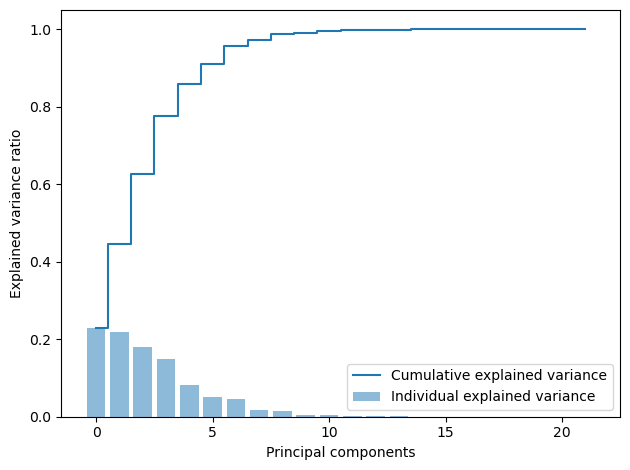

In [305]:
# Instantiate PCA
pca = PCA()
# Determine transformed features
z = pca.fit_transform(z)
# Determine explained variances and the cumulative sum
exp_var_pca = pca.explained_variance_ratio_
cum_sum_eigenvalues = np.cumsum(exp_var_pca)
# Plot
plt.bar(range(0,len(exp_var_pca)), exp_var_pca, alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(0,len(cum_sum_eigenvalues)), cum_sum_eigenvalues, where='mid',label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

In [306]:
len(cum_sum_eigenvalues[cum_sum_eigenvalues<0.70])+1

4

We can notice that the first 4 principal components explain more than 70% of variance so now we want to create a dataframe with only these 4 components.

In [307]:
pca1 = PCA(n_components=4)
PCA_f = pca1.fit_transform(newdf)
PCA_DF = pd.DataFrame(data = PCA_f, columns = ['pc1', 'pc2','pc3', 'pc4'])
PCA_DF.to_pickle("pcadf")

## 2.3 Clustering!

#### MapReduce in pySpark

In [308]:
df = pd.read_pickle("pcadf")

In [309]:
# Pyspark initialization
findspark.init()
spark = SparkSession.builder.master("local[4]").getOrCreate()

In [310]:
df = pd.read_pickle("pcadf")
values = df.values.tolist()
sdf = spark.createDataFrame(values,["pc1","pc2","pc3","pc4"])

In the following cell is presented the code for the kmeans algorithm

In [314]:
k = 5
rdd = sdf.rdd.map(list)
vectorized_rdd = rdd.map(lambda row: np.array(row))

def distance(x, y):
    distance = np.zeros(len(y))
    for i in range(len(y)):         
        distance[i] = np.linalg.norm(x-y[i])
    key = np.argmin(distance)
    return (key, x)

init_c = np.array(df.sample(k))

diff = 999
while diff > 0.01:  # threshold for shortening computation time
    d = vectorized_rdd.map(lambda row: distance(row,init_c))
    updated_c = d.groupByKey().mapValues(lambda row: sum(row)/len(row)).collect()
    
    K_new = {}                               #
    for i in updated_c:                      # 
        K_new[i[0]]=i[1]                     # this block of code exists to keep
    finalist = []                            # track of the index of each centroid
    for i in range(k):                       #
        finalist.append(np.array(K_new[i]))  #
    final_c = np.array(finalist)
    
    diff = np.linalg.norm(final_c-init_c)
    init_c = final_c
    print(diff)  # printing out the difference value to monitor the execution of the algorithm
    
print(init_c)

0.7881772832013271
0.25973991315893136
0.19214808407731243
0.13796356540994986
0.1275126646699794
0.15312308312298759
0.17944529209684135
0.1756249592069066
0.14154886104033457
0.10569371086188888
0.07854345729832705
0.0641667592748653
0.05950177051352733
0.06147252594119607
0.0715624060179546
0.1071354975226038
0.1882191203164741
0.2347810922771789
0.17388908951232596
0.08989271570855932
0.04368019213754975
0.02042393037548946
0.008903463774776155
[[-4.13872164e-01  3.36667485e-01 -3.75862412e-01 -5.16141093e-04]
 [ 6.86680284e-02 -3.36964894e-02  1.73461222e-01  5.96167776e-01]
 [ 7.13551500e-01  2.07320905e-01 -1.46258015e-01 -1.17159215e-01]
 [-2.27635535e-01  1.57317551e-01  6.14979601e-01 -2.69687771e-01]
 [-1.04888713e-01 -6.24457224e-01 -1.83771796e-01 -9.64579643e-02]]


#### Optimal clustering
We will use the methods of the elbow and the silhouette to find out what is the optimal number of clusters in terms of scoring function and overlap. In this section will be used the already implemented version of kmeans inside sklearn

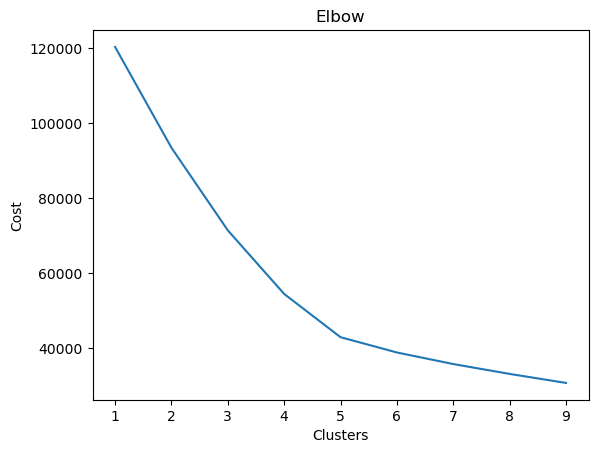

In [311]:
model = {}
for k in range(1,10):
    kmeans = KMeans(n_clusters=k).fit(df)
    model[k] = kmeans.inertia_
    
plt.figure()
plt.plot(list(model.keys()), list(model.values()))
plt.xlabel('Clusters')
plt.ylabel('Cost')
plt.title('Elbow')
plt.show()

The elbow method gives as optimal numbers of clusters a range between 4 and 6

Silhouette scores:

In [329]:
for i in range(2,10):
    labels = KMeans(n_clusters=i).fit(df).labels_
    print(str(i)+"=="+str(sklearn.metrics.silhouette_score(df,labels,sample_size=1000)))

2==0.5127119777381354
3==0.4790698734895891
4==0.5260777892125715
5==0.5718836782846851
6==0.5371146717212117
7==0.4566277424361988
8==0.39296592784872725
9==0.3378855206173493


#### Observations
As we can see from the values of the silhouette scores, the clusters could have a bit of overlap. Nevertheless we can conclude that in this case the optimal number of clusters will be 5 as it yields the highest silhouette score and it is in line with the results of the elbow method.

Comparing our kmeans algorithm with the version of kmeans++ implemented in the sklearn package, it can be seen that the resulting centroids are very similar vecors (the order is shuffled), this discrepancy is due to the threshold we opted to use in our version for time saving reasons. This last consideration points out the main difference between the sklearn version and ours, which is the running time, as the former is way faster.

In [317]:
kmeans = KMeans(n_clusters=5, init='k-means++').fit(df)
kmeans.cluster_centers_

array([[-0.4133628 ,  0.3371435 , -0.37620584, -0.00173938],
       [-0.22741427,  0.15753878,  0.61495363, -0.26987298],
       [-0.10402746, -0.62448444, -0.18435195, -0.09834787],
       [ 0.71345646,  0.20794369, -0.14505516, -0.11432898],
       [ 0.06395353, -0.03688398,  0.17278731,  0.59666038]])

In [316]:
final_c

array([[-4.13872164e-01,  3.36667485e-01, -3.75862412e-01,
        -5.16141093e-04],
       [ 6.86680284e-02, -3.36964894e-02,  1.73461222e-01,
         5.96167776e-01],
       [ 7.13551500e-01,  2.07320905e-01, -1.46258015e-01,
        -1.17159215e-01],
       [-2.27635535e-01,  1.57317551e-01,  6.14979601e-01,
        -2.69687771e-01],
       [-1.04888713e-01, -6.24457224e-01, -1.83771796e-01,
        -9.64579643e-02]])

## 2.4 Analysing your results!

We created a new column that shows the cluster to which each row belongs. Then we choose the average transaction, balance and total expences as more relevant variables relevant to identify the cluster of each customer. With the three functions below we want to divide in 4 classes each variable.

In [318]:
kmeans = KMeans(n_clusters=5, init='k-means++')
df["cluster"] = kmeans.fit_predict(df)

In [319]:
ogdf = pd.read_pickle("2.1")

In [320]:
def classTransactions(x):
    if x < 1000: return("0-1000")
    elif x <2500: return("1000-2500")
    elif x < 4000: return("2500-4000")
    else: return(">4000")
        
def classBalance(x):
    if x < 10000: return("0-10000")
    elif x <50000: return("10000-50000")
    elif x < 200000: return("50000-200000")
    else: return(">200000")
    
def classExpenses(x):
    if x < 1000: return("0-1000")
    elif x <5000: return("1000-5000")
    elif x < 20000: return("5000-20000")
    else: return(">20000")

In [321]:
ogdf["cluster"] = df["cluster"]
ogdf["Transactions_class"] = ogdf.Ave_transaction.apply(lambda row: classTransactions(row))
ogdf["Balance_class"] = ogdf.Balance.apply(lambda row: classBalance(row))
ogdf["Expenses_class"] = ogdf.Total_expenses.apply(lambda row: classExpenses(row))

Now that we have 3 new columns to show the class to which each row belongs, we want to create for each variable a pivot table normalized for rows.

In [248]:
pivot1 = round(pd.crosstab(index=ogdf.cluster, columns=ogdf.Transactions_class, values=ogdf.Ave_transaction, aggfunc="count", normalize="index")*100,1)
pivot2 = round(pd.crosstab(index=ogdf.cluster, columns=ogdf.Balance_class, values=ogdf.Balance, aggfunc="count", normalize="index")*100,1)
pivot3 = round(pd.crosstab(index=ogdf.cluster, columns=ogdf.Expenses_class, values=ogdf.Total_expenses, aggfunc="count", normalize="index")*100,1)

In [249]:
pivot1

Transactions_class,0-1000,1000-2500,2500-4000,>4000
cluster,,,,
0,33.9,28.5,11.4,26.2
1,60.6,27.2,6.0,6.1
2,62.4,25.1,6.3,6.2
3,69.1,22.5,5.0,3.5
4,64.9,24.2,5.9,4.9


In [250]:
pivot2

Balance_class,0-10000,10000-50000,50000-200000,>200000
cluster,,,,
0,25.4,29.8,22.2,22.6
1,35.9,35.5,18.5,10.2
2,48.9,33.8,12.2,5.1
3,51.0,32.6,12.5,4.0
4,50.0,31.6,13.3,5.1


In [251]:
pivot3

Expenses_class,0-1000,1000-5000,5000-20000,>20000
cluster,,,,
0,18.6,32.9,33.6,14.9
1,2.6,20.5,46.4,30.5
2,34.3,44.5,19.1,2.1
3,38.8,44.5,16.2,0.5
4,41.3,41.5,16.3,0.9


#### Observations
1. Transactions: Clusters from 1 to 4 have a similar trend regarding the average transaction amount, in particular we see that the majority of the transactions belong to the lower ranges, and cluster 3 has a more extreme behaviour with respect to the other three.

2. Balance: Also in this case the first cluster has a different trend from the others, having all four classes with similar percentages. In cluster 1 and even more in clusters 2, 3 and 4 the percentage about the lower class increases a lot, reaching values above 50%. Going through the other classes we can notice that clusters 2, 3 and 4 have a similar trend with low values for balances above 200000.

3. Expenses: In the case of the total expenses, we can see that clusters 3 and 4 have a very similar trend of percentages across the classes. Cluster 1 has peaks in the higher classes, having also a very low percentage of small expenses. Cluster 0 exhibits a more balanced trend across the classes, hinting to a gaussian distribution.

Summing up these observations we can conclude that Cluster 0 is composed by the wealthier people, Cluster 1 contains people more prone to spend money. Clusters 2, 3 and 4 are more representative of the behaviour of an average consumer, with Cluster 2 deviating a bit towards the behaviour of the upper clusters.

Silhouette score evaluation:

In [326]:
labels = KMeans(n_clusters=5).fit(df).labels_
print(str(sklearn.metrics.silhouette_score(df,labels)))

0.56703341333095


This silhouette score indicates a bit of overlap between the clusters, as expected after seeing the behaviours of the pivot tables and from the rough evaluation in point 2.3. The clustering performance in our opinion is overall acceptable.

## Algorithmic Question

The idea behind this algorithm is to tranform the time interval between opening and closure $t$ of an entrance into a segment of length $t$, doing so the maximum number of superpositions between these segments for each unit of time will be the minimum number of guards required.

In [327]:
input_list = list(input().split())
M = list(map(int, input().split()))
doors = set(M)
array = np.array(M)

# transformation
D = {}
for i in doors:
    temp = np.where(array==i)[0]
    D[i] = set(range(min(temp),max(temp)+1))
    
# count of intersections
count = []
for i in range(len(array)):
    c=0
    for j in D.keys():
        if i in D[j]: c+=1
    count.append(c)

# output
if int(input_list[2])<max(count): print("NO")
else: print("YES")

6 10 3
1 2 3 1 4 4 3 1 5 3
YES
